# Creation of the Dataset

### Importations 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import pyroomacoustics as pra
import pickle as pkl
import pandas as pd
from scipy.io import wavfile
from scipy.signal import fftconvolve
from scipy import signal
from matplotlib import gridspec
import random

### Function that computes the absorption out of the room dimensions and the RT60.

In [2]:
def compute_absorption(room_eadge,room_height,RT60):
    V = (room_eadge**2)*room_height
    S = 2*(room_eadge**2) + 4*(room_height**2)
    absr = 0.1611*(V/(S*RT60))
    return absr

### Setting the different parameters for the rooms

In [3]:
#Here You should put the path to where the file wav is on the machine you are working on.
folder_path = "/home/janjar/Semester_Project/Dataset/GDWN/WGN.wav"
file_to_open = folder_path 

ang = (np.array([61.]) / 180.) * np.pi
distance = 1.0
a = np.array([5.,5.,3.])
b = np.array([6.,6.,3.])
dimensions = np.stack((a,b))
distances = np.array([1.,2.])
RT60 = np.array([0.2,0.3])

absorption_1 = compute_absorption(a[0],a[2],RT60[0])
absorption_2 = compute_absorption(b[0],b[2],RT60[1])
absorptions = np.array([absorption_1,absorption_2])

DOAs = np.linspace(0, 180, 37)
print(DOAs)
x_y_position = np.array([random.uniform(0.5, 4.5),random.uniform(0.5, 4.5),random.uniform(0.5, 2.5)])
print(x_y_position)



snr = 1000.
fs,signal_wav = wavfile.read(file_to_open)
snrs = np.array([5,10,15,20])
white_noise = np.random.normal(0.0,0.5,44100*2)

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180.]
[2.65222695 4.18452869 1.58033773]


## Methode that generates a room out of the conditions given in argument.
### Returns the audio_signals for the 4 mics, the location of the source and the absorption of the room .

In [4]:
def generate_room_from_conditions(signal,array_position,ang,distance,absorptions,snr,dimensions,typeofroom):
   
    room_dim = dimensions[typeofroom]
    room_eadge = room_dim[0]

    sf = (0.03*np.sqrt(2)/4)
    corners = np.array([[0,0],[0,room_eadge],[room_eadge,room_eadge],[room_eadge,0]]).T
    
    absr = absorptions[typeofroom]
    room = pra.Room.from_corners(corners, fs=fs , max_order=8 ,absorption=absorptions[typeofroom])
    room.extrude(3.)

    # Add sources of 1 second duration
    #room_dim = np.array([5,5,3])
    rng = np.random.RandomState(23)
    duration_samples = int(fs)


    source_location = room_dim / 2 + (distance * np.array([np.cos(ang), np.sin(ang),0.0]))
    source_signal = rng.randn(duration_samples)
    room.add_source(source_location, signal = signal)
    #print('Here is the source at this step:',source_location) 

    #We initiate the point of the Tethra then we scale them
    #and translate the origin of the Tethra to the center of the room.
    R = np.array([(sf*np.array([1,1,-1,-1]))+array_position[0],(sf*np.array([1,-1,1,-1]))+array_position[1],(sf*np.array([1,-1,-1,1]))+array_position[2]])# [[x], [y], [z]]
    room.add_microphone_array(pra.MicrophoneArray(R,room.fs))
    room.image_source_model(use_libroom=True)
    #print("Here is the location of the mic-array:",R)

    #Visualization
    #fig, ax = room.plot(img_order=3)
    #fig.set_size_inches(18.5,10.5)

    room.simulate(snr = snr)
    #print('Here is the audio signal:',room.mic_array.signals[0][:5])
    return room,room.mic_array.signals,source_location,absr

### Testing that generate_room works properly

In [5]:
ang = (np.array([70.]) / 180.) * np.pi
ang1 = (np.array([170.0]) / 180.) * np.pi
room1,audio_signals,source_loc,t = generate_room_from_conditions(white_noise,x_y_position,DOAs[0],distances[1],absorptions,snr,dimensions,1)
room2,audio_signals1,source_loc1,t1 = generate_room_from_conditions(white_noise,x_y_position,DOAs[1],distances[1],absorptions,snr,dimensions,1)
print(audio_signals[0,:].shape)

(95084,)


In [6]:
f, t, stft = signal.stft(audio_signals[0,:].astype(np.float32),nperseg=512)
f.shape
t.shape
stft.shape



(257, 373)

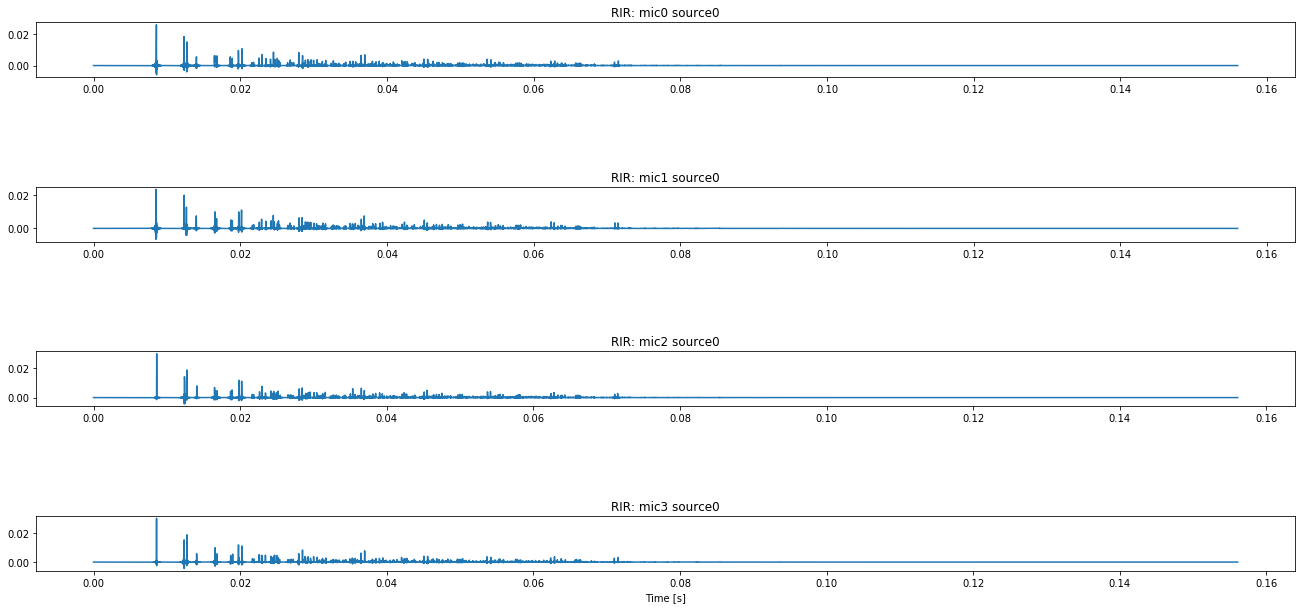

In [7]:
#Plotting the RIR for each microphone
room1.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

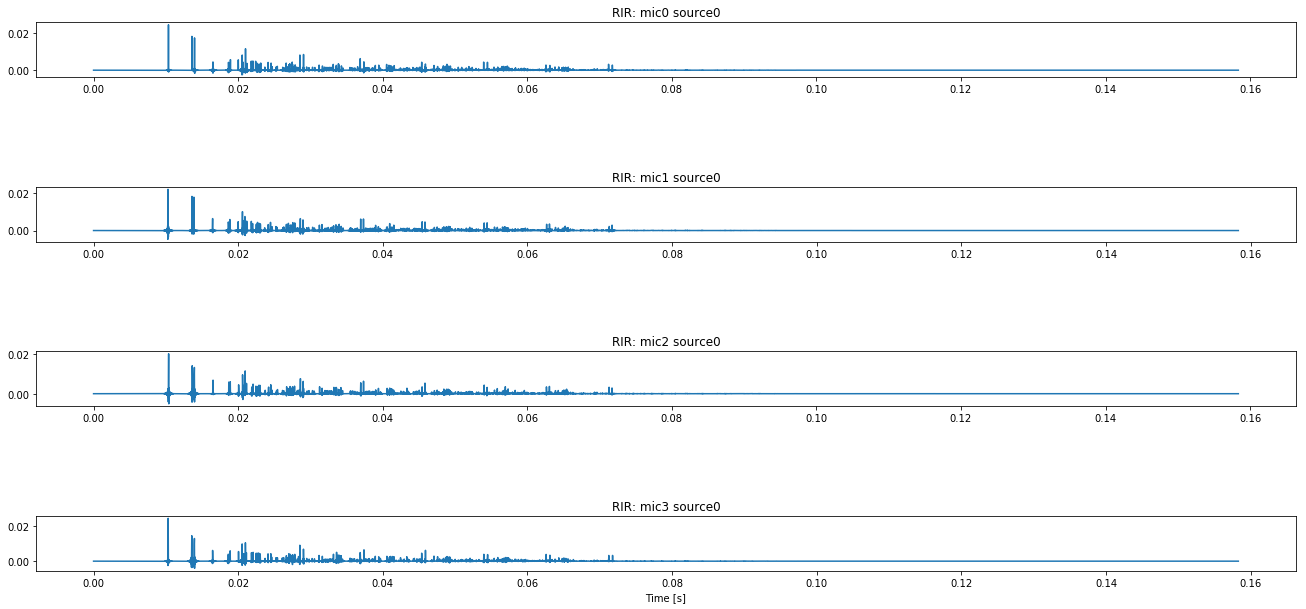

In [8]:
#Plotting the RIR for each microphone
room2.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

In [9]:
print(audio_signals1==audio_signals)

False


/home/janjar/test/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


## Method that compute the phasematrix out of a signal and store it in the training folder.
### Returns the paths to the audio_file and the phase_matrix.

In [10]:
def generate_phasematrix_from_signals(signals,j):
    
    #Here also the path should be the folder you need the audio files to be stored on.
        path = "/home/janjar/Dataset/Trainingset/"   
        name_signals = 'audio_signals/audio_signals-{}'.format(j)
        fileName_audio = path + name_signals
        fileObject = open(fileName_audio, 'wb')
        pkl.dump(signals, fileObject)
        fileObject.close()                
    
        phase_matrix = np.zeros((4, 256, 360))
        
        #print("Ici elle doit etre vide",phase_matrix)
        for i in range(4):
            f, t, stft_mic0 = signal.stft(signals[i,:].astype(np.float32), nperseg=512)
            spectrum = stft_mic0
            #print("shape of the STFT:",spectrum.shape)
            magnitude = np.abs(spectrum)
            phase = np.angle(spectrum)
            #print('Here is the phase:',phase.shape)
            #print("HERE IS THE SHAPE",phase.shape)
            #phase_matrix = np.empty((4, x, y))
            phase_matrix[i] = phase[:256,:360]
        
        
        #print("Matrice finale",phase_matrix)
        path = "/home/janjar/Dataset/Trainingset/"   
        name_matrix = 'phase_matrix/Phase_matrix-{}'.format(j)
        fileName_matrix = path + name_matrix
        fileObject = open(fileName_matrix, 'wb')
        pkl.dump(phase_matrix, fileObject)
        fileObject.close()                    
        return fileName_audio,fileName_matrix,phase_matrix

### Testing that generate_phasematrix works properly

In [11]:
path_to_audio,path_to_matrix,_ = generate_phasematrix_from_signals(audio_signals1,0)


In [12]:
np.array_equal(audio_signals, audio_signals1)

False

In [13]:
_,_,phase0 = generate_phasematrix_from_signals(audio_signals,0)
_,_,phase1 = generate_phasematrix_from_signals(audio_signals1,1)

In [14]:
print(phase0.shape,phase1.shape)

(4, 256, 360) (4, 256, 360)


In [15]:
np.array_equal(phase0, phase1)

False

### Funtion to assign the right label to each angle.

In [16]:
def assign_label_to_anlges(angles):    
    bins = np.linspace(0, 180, 37)
    label = np.digitize(angles, bins)
    return label-1


In [17]:
assign_label_to_anlges(DOAs)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

## The main function that generate the entire Dataset set including the Dataframe to represent it.
### Return the Dataframe representing the training set.

In [18]:
def genere_dataset():
        index = 0
        df = pd.DataFrame(columns = ['Room','Array_position','Distance','Absorption','SNR','Audio_file','Phase_Matrix','Label'])
        snr = np.array([0,5,10,15,20]) #Comment this part to turn the snr into random assignment for each room
	#We iterate over the type of rooms (R1,R2).
        for i in range (2):          
	#We iterate over the distances from the microphones (1m,2m).	
            for j in range(2):
	#We iterate on the 7 random positions of the array.		
                for k in range(7):
	#We iterate on the 37 random positions of the source.		            
                    for l in range(37):
                    
                        print('Room:',index)
                        #angles = np.random.uniform(low=0, high=179, size=(7,))
                        #print(angles)
                        #print('Here are the angles for this Room:',angles) #Make the angles able to go to floats.
                        label = assign_label_to_anlges(DOAs[l])
                        #print('Here are the labels for this Room:',labels) #Check if the labels match the angles.
                        #azimuth = angles / 180. * np.pi 
                        snr = snrs[np.random.randint(4,size = 1)] # Uncomment this part to turn the snr into random assignment for each room
                        white_noise = np.random.normal(0.0,random.uniform(0, 1),44100*2)
                        array_position = np.array([random.uniform(0.5, 4.5),random.uniform(0.5, 4.5),random.uniform(0.5, 2.5)])
                        _,signals,array_position,absr = generate_room_from_conditions(white_noise,array_position,DOAs[l],distances[j],absorptions,snr,dimensions,i)
                        fileName_audio,fileName_matrix,_ = generate_phasematrix_from_signals(signals,index)
                        df = df.append({'Room':i,'Array_position':array_position,'Angle':DOAs[l],'Distance':distances[j],'Absorption':absr,'SNR':snr,'Audio_file':fileName_audio,'Phase_Matrix':fileName_matrix,'Label':label} , ignore_index=True)
                        index = index+1
        return df               



In [19]:
Dataset = genere_dataset()

Room: 0
Room: 1
Room: 2
Room: 3
Room: 4
Room: 5
Room: 6
Room: 7
Room: 8
Room: 9
Room: 10
Room: 11
Room: 12
Room: 13
Room: 14
Room: 15
Room: 16
Room: 17
Room: 18
Room: 19
Room: 20
Room: 21
Room: 22
Room: 23
Room: 24
Room: 25
Room: 26
Room: 27
Room: 28
Room: 29
Room: 30
Room: 31
Room: 32
Room: 33
Room: 34
Room: 35
Room: 36
Room: 37
Room: 38
Room: 39
Room: 40
Room: 41
Room: 42
Room: 43
Room: 44
Room: 45
Room: 46
Room: 47
Room: 48
Room: 49
Room: 50
Room: 51
Room: 52
Room: 53
Room: 54
Room: 55
Room: 56
Room: 57
Room: 58
Room: 59
Room: 60
Room: 61
Room: 62
Room: 63
Room: 64
Room: 65
Room: 66
Room: 67
Room: 68
Room: 69
Room: 70
Room: 71
Room: 72
Room: 73
Room: 74
Room: 75
Room: 76
Room: 77
Room: 78
Room: 79
Room: 80
Room: 81
Room: 82
Room: 83
Room: 84
Room: 85
Room: 86
Room: 87
Room: 88
Room: 89
Room: 90
Room: 91
Room: 92
Room: 93
Room: 94
Room: 95
Room: 96
Room: 97
Room: 98
Room: 99
Room: 100
Room: 101
Room: 102
Room: 103
Room: 104
Room: 105
Room: 106
Room: 107
Room: 108
Room: 109
Room: 110


Room: 831
Room: 832
Room: 833
Room: 834
Room: 835
Room: 836
Room: 837
Room: 838
Room: 839
Room: 840
Room: 841
Room: 842
Room: 843
Room: 844
Room: 845
Room: 846
Room: 847
Room: 848
Room: 849
Room: 850
Room: 851
Room: 852
Room: 853
Room: 854
Room: 855
Room: 856
Room: 857
Room: 858
Room: 859
Room: 860
Room: 861
Room: 862
Room: 863
Room: 864
Room: 865
Room: 866
Room: 867
Room: 868
Room: 869
Room: 870
Room: 871
Room: 872
Room: 873
Room: 874
Room: 875
Room: 876
Room: 877
Room: 878
Room: 879
Room: 880
Room: 881
Room: 882
Room: 883
Room: 884
Room: 885
Room: 886
Room: 887
Room: 888
Room: 889
Room: 890
Room: 891
Room: 892
Room: 893
Room: 894
Room: 895
Room: 896
Room: 897
Room: 898
Room: 899
Room: 900
Room: 901
Room: 902
Room: 903
Room: 904
Room: 905
Room: 906
Room: 907
Room: 908
Room: 909
Room: 910
Room: 911
Room: 912
Room: 913
Room: 914
Room: 915
Room: 916
Room: 917
Room: 918
Room: 919
Room: 920
Room: 921
Room: 922
Room: 923
Room: 924
Room: 925
Room: 926
Room: 927
Room: 928
Room: 929
Room: 930


In [20]:
Dataset

,Room,Array_position,Distance,Absorption,SNR,Audio_file,Phase_Matrix,Label,Angle
0,0,"[3.5, 2.5, 1.5]",1.0,0.702471,[10],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,0,0.0
1,0,"[2.783662185463226, 1.5410757253368614, 1.5]",1.0,0.702471,[5],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,1,5.0
2,0,"[1.6609284709235475, 1.9559788891106302, 1.5]",1.0,0.702471,[10],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,2,10.0
3,0,"[1.7403120871411786, 3.150287840157117, 1.5]",1.0,0.702471,[20],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,3,15.0
4,0,"[2.908082061813392, 3.4129452507276277, 1.5]",1.0,0.702471,[5],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,4,20.0
5,0,"[3.4912028118634737, 2.367648249902227, 1.5]",1.0,0.702471,[20],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,5,25.0
6,0,"[2.654251449887584, 1.5119683759071383, 1.5]",1.0,0.702471,[5],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,6,30.0
7,0,"[1.5963077949084932, 2.071817330503849, 1.5]",1.0,0.702471,[20],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,7,35.0
8,0,"[1.833061938347738, 3.245113160479349, 1.5]",1.0,0.702471,[5],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,8,40.0
9,0,"[3.02532198881773, 3.3509035245341185, 1.5]",1.0,0.702471,[20],/home/janjar/Dataset/Trainingset/audio_signals...,/home/janjar/Dataset/Trainingset/phase_matrix/...,9,45.0


### Saving the Dataframe into a pickle to use it for the Training

In [21]:
Dataset.to_pickle("/home/janjar/Dataset/Trainingset/Training_dataframe.pkl")